# Connect notebook to google drive

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


# Put celeba in your google drive/data 
https://drive.google.com/drive/folders/1DhLiHPQUgpP-y65ua9oynNy_EZj4ueli?usp=sharing

In [0]:
!rm img_align_celeba.zip

In [0]:
!ls /content/drive/My\ Drive/data/

celeba-dataset.zip  img_align_celeba.zip


In [0]:
!apt-get install pv

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pv is already the newest version (1.6.6-1).
0 upgraded, 0 newly installed, 0 to remove and 28 not upgraded.


In [0]:
# !rm -rf drive/My\ Drive/data/img_align_celeba
!pv drive/My\ Drive/data/celeba-dataset.zip > /content/img_align_celeba.zip

1.33GiB 0:00:52 [26.0MiB/s] [================================>] 100%            


In [0]:
!unzip -q /content/img_align_celeba.zip

In [0]:
import os
os.chdir('/content/')

In [0]:
%matplotlib inline

In [0]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


Inputs
------

Let’s define some inputs for the run:

-  **dataroot** - the path to the root of the dataset folder. We will
   talk more about the dataset in the next section
-  **workers** - the number of worker threads for loading the data with
   the DataLoader
-  **batch_size** - the batch size used in training. The DCGAN paper
   uses a batch size of 128
-  **image_size** - the spatial size of the images used for training.
   This implementation defaults to 64x64. If another size is desired,
   the structures of D and G must be changed. See
   `here <https://github.com/pytorch/examples/issues/70>`__ for more
   details
-  **nc** - number of color channels in the input images. For color
   images this is 3
-  **nz** - length of latent vector
-  **ngf** - relates to the depth of feature maps carried through the
   generator
-  **ndf** - sets the depth of feature maps propagated through the
   discriminator
-  **num_epochs** - number of training epochs to run. Training for
   longer will probably lead to better results but will also take much
   longer
-  **lr** - learning rate for training. As described in the DCGAN paper,
   this number should be 0.0002
-  **beta1** - beta1 hyperparameter for Adam optimizers. As described in
   paper, this number should be 0.5
-  **ngpu** - number of GPUs available. If this is 0, code will run in
   CPU mode. If this number is greater than 0 it will run on that number
   of GPUs




In [0]:
# Root directory for dataset
dataroot = "/content/img_align_celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [0]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder('/content/img_align_celeba',
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

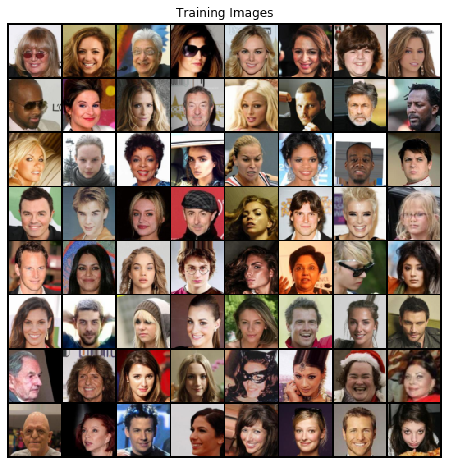

In [0]:

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [0]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


Discriminator Code



In [0]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [0]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [0]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Starting Training Loop...
[0/10][0/1583]	Loss_D: 0.6056	Loss_G: 4.6158	D(x): 0.8429	D(G(z)): 0.2952 / 0.0169
2019-11-07 13:50:50.691595
[0/10][50/1583]	Loss_D: 0.8419	Loss_G: 6.1466	D(x): 0.8967	D(G(z)): 0.4409 / 0.0056
2019-11-07 13:51:11.063760
[0/10][100/1583]	Loss_D: 0.4153	Loss_G: 3.4347	D(x): 0.8275	D(G(z)): 0.1652 / 0.0492
2019-11-07 13:51:31.274361
[0/10][150/1583]	Loss_D: 0.4942	Loss_G: 3.9867	D(x): 0.9103	D(G(z)): 0.2783 / 0.0362
2019-11-07 13:51:51.475295
[0/10][200/1583]	Loss_D: 1.8806	Loss_G: 2.5103	D(x): 0.2769	D(G(z)): 0.0045 / 0.1402
2019-11-07 13:52:11.651475
[0/10][250/1583]	Loss_D: 0.6926	Loss_G: 3.0968	D(x): 0.7663	D(G(z)): 0.2508 / 0.0800
2019-11-07 13:52:31.736965
[0/10][300/1583]	Loss_D: 0.6669	Loss_G: 4.8842	D(x): 0.9567	D(G(z)): 0.4084 / 0.0158
2019-11-07 13:52:51.848720
[0/10][350/1583]	Loss_D: 0.8910	Loss_G: 1.0780	D(x): 0.5332	D(G(z)): 0.0341 / 0.4537
2019-11-07 13:53:12.022292
[0/10][400/1583]	Loss_D: 0.7449	Loss_G: 2.1208	D(x): 0.5804	D(G(z)): 0.0295 / 0.1

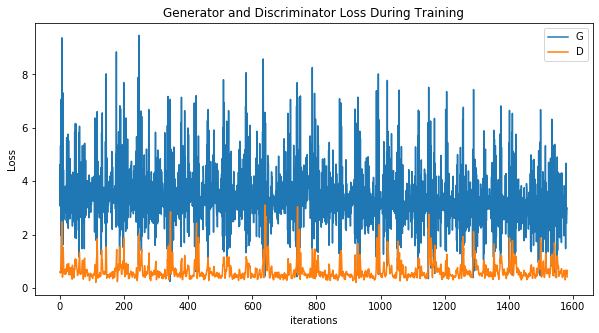

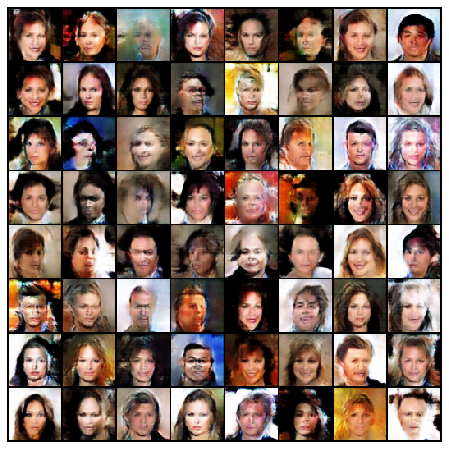

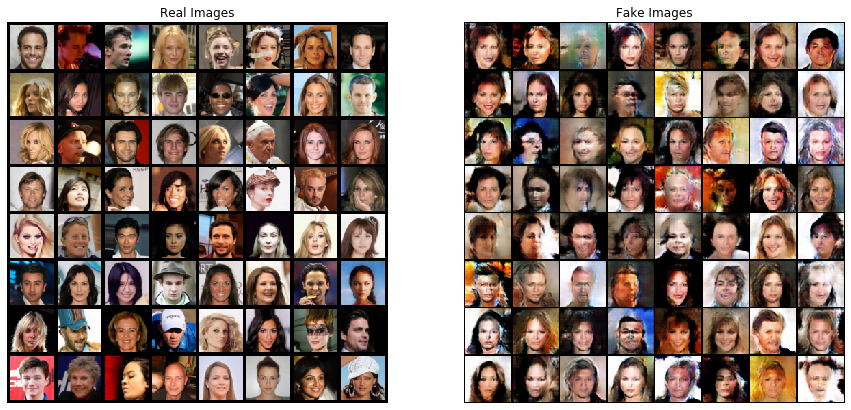

[1/10][0/1583]	Loss_D: 0.4622	Loss_G: 2.6257	D(x): 0.8074	D(G(z)): 0.1797 / 0.0915
2019-11-07 14:01:35.292612
[1/10][50/1583]	Loss_D: 0.9025	Loss_G: 4.0774	D(x): 0.8975	D(G(z)): 0.4909 / 0.0279
2019-11-07 14:01:55.479642
[1/10][100/1583]	Loss_D: 0.4719	Loss_G: 2.2836	D(x): 0.7459	D(G(z)): 0.1280 / 0.1468
2019-11-07 14:02:15.574971
[1/10][150/1583]	Loss_D: 0.8186	Loss_G: 1.5764	D(x): 0.6024	D(G(z)): 0.1575 / 0.2529
2019-11-07 14:02:35.648329
[1/10][200/1583]	Loss_D: 0.4375	Loss_G: 3.6884	D(x): 0.9013	D(G(z)): 0.2599 / 0.0339
2019-11-07 14:02:55.730772
[1/10][250/1583]	Loss_D: 0.4497	Loss_G: 2.4821	D(x): 0.7677	D(G(z)): 0.1263 / 0.1121
2019-11-07 14:03:15.832069
[1/10][300/1583]	Loss_D: 0.6189	Loss_G: 2.2821	D(x): 0.6910	D(G(z)): 0.1644 / 0.1414
2019-11-07 14:03:35.921574
[1/10][350/1583]	Loss_D: 0.4332	Loss_G: 2.6839	D(x): 0.8219	D(G(z)): 0.1791 / 0.0878
2019-11-07 14:03:56.003954
[1/10][400/1583]	Loss_D: 0.7808	Loss_G: 1.5306	D(x): 0.5566	D(G(z)): 0.0727 / 0.2811
2019-11-07 14:04:16.10

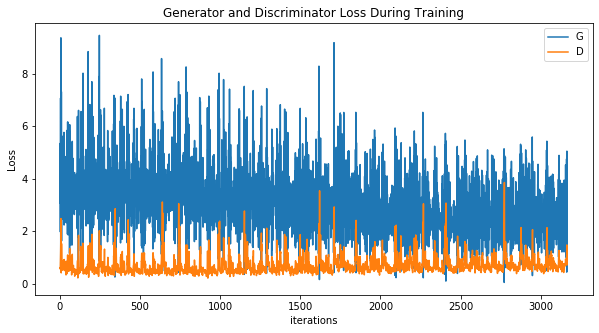

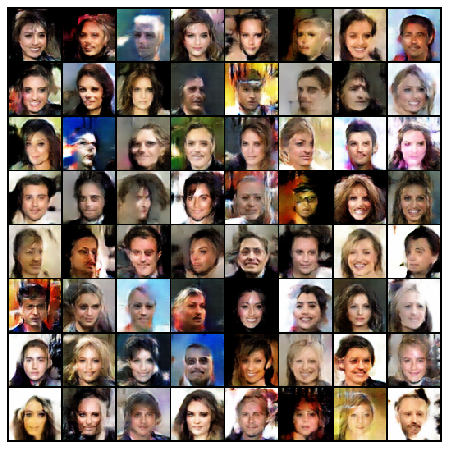

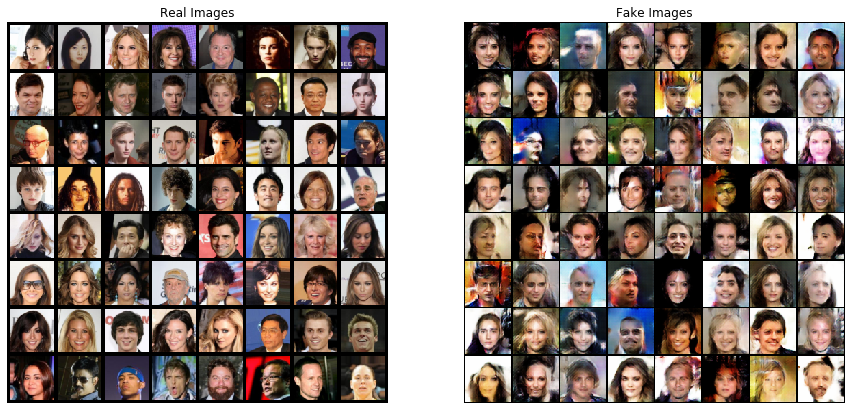

[2/10][0/1583]	Loss_D: 0.6952	Loss_G: 2.0923	D(x): 0.6808	D(G(z)): 0.1773 / 0.1707
2019-11-07 14:12:15.944119
[2/10][50/1583]	Loss_D: 0.8131	Loss_G: 4.2341	D(x): 0.9495	D(G(z)): 0.4826 / 0.0237
2019-11-07 14:12:36.018698
[2/10][100/1583]	Loss_D: 0.9565	Loss_G: 3.9612	D(x): 0.9003	D(G(z)): 0.5092 / 0.0319
2019-11-07 14:12:56.113759
[2/10][150/1583]	Loss_D: 0.5819	Loss_G: 2.8197	D(x): 0.8292	D(G(z)): 0.2933 / 0.0788
2019-11-07 14:13:16.200135
[2/10][200/1583]	Loss_D: 0.7849	Loss_G: 3.3954	D(x): 0.8286	D(G(z)): 0.4040 / 0.0460
2019-11-07 14:13:36.280309
[2/10][250/1583]	Loss_D: 0.4660	Loss_G: 2.7159	D(x): 0.8255	D(G(z)): 0.2119 / 0.0851
2019-11-07 14:13:56.379432
[2/10][300/1583]	Loss_D: 1.1333	Loss_G: 4.4066	D(x): 0.8883	D(G(z)): 0.5806 / 0.0190
2019-11-07 14:14:16.470919
[2/10][350/1583]	Loss_D: 0.8368	Loss_G: 3.3706	D(x): 0.8987	D(G(z)): 0.4667 / 0.0516
2019-11-07 14:14:36.658373
[2/10][400/1583]	Loss_D: 0.5365	Loss_G: 2.3955	D(x): 0.8192	D(G(z)): 0.2571 / 0.1157
2019-11-07 14:14:56.75

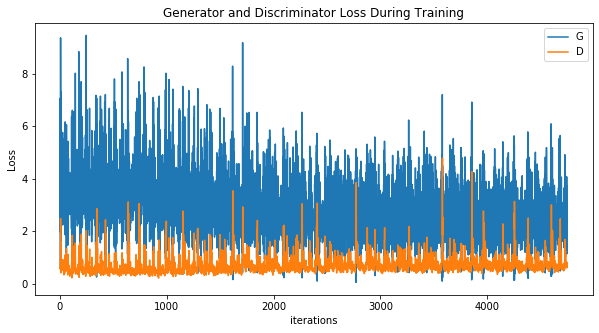

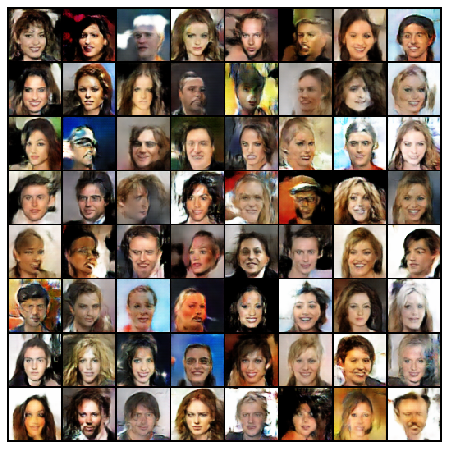

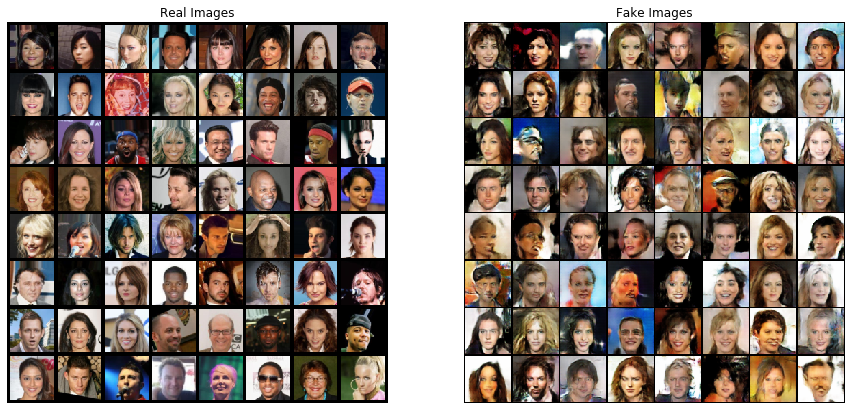

[3/10][0/1583]	Loss_D: 0.7797	Loss_G: 3.7428	D(x): 0.9403	D(G(z)): 0.4717 / 0.0324
2019-11-07 14:22:56.940957
[3/10][50/1583]	Loss_D: 0.7675	Loss_G: 1.7762	D(x): 0.5603	D(G(z)): 0.0794 / 0.2130
2019-11-07 14:23:17.061242
[3/10][100/1583]	Loss_D: 1.0189	Loss_G: 3.4064	D(x): 0.7786	D(G(z)): 0.4638 / 0.0513
2019-11-07 14:23:37.146842
[3/10][150/1583]	Loss_D: 0.5611	Loss_G: 2.7445	D(x): 0.8238	D(G(z)): 0.2726 / 0.0857
2019-11-07 14:23:57.233355
[3/10][200/1583]	Loss_D: 0.5941	Loss_G: 2.5079	D(x): 0.8311	D(G(z)): 0.3002 / 0.1055
2019-11-07 14:24:17.325408
[3/10][250/1583]	Loss_D: 0.8625	Loss_G: 3.2751	D(x): 0.8090	D(G(z)): 0.4334 / 0.0507
2019-11-07 14:24:37.415782
[3/10][300/1583]	Loss_D: 0.5330	Loss_G: 3.0008	D(x): 0.8329	D(G(z)): 0.2581 / 0.0658
2019-11-07 14:24:57.620041
[3/10][350/1583]	Loss_D: 0.8055	Loss_G: 4.2064	D(x): 0.9093	D(G(z)): 0.4697 / 0.0211
2019-11-07 14:25:17.707946
[3/10][400/1583]	Loss_D: 0.5248	Loss_G: 2.0496	D(x): 0.7375	D(G(z)): 0.1683 / 0.1581
2019-11-07 14:25:37.80

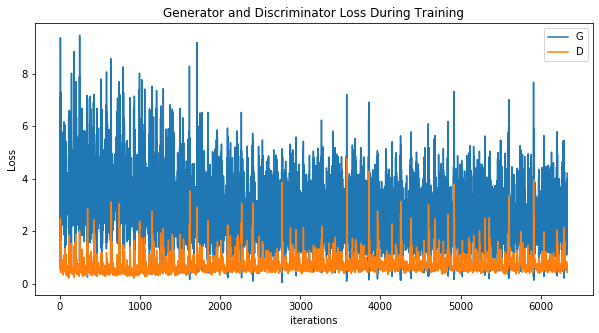

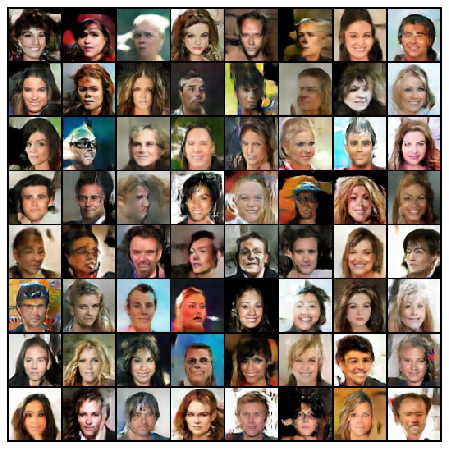

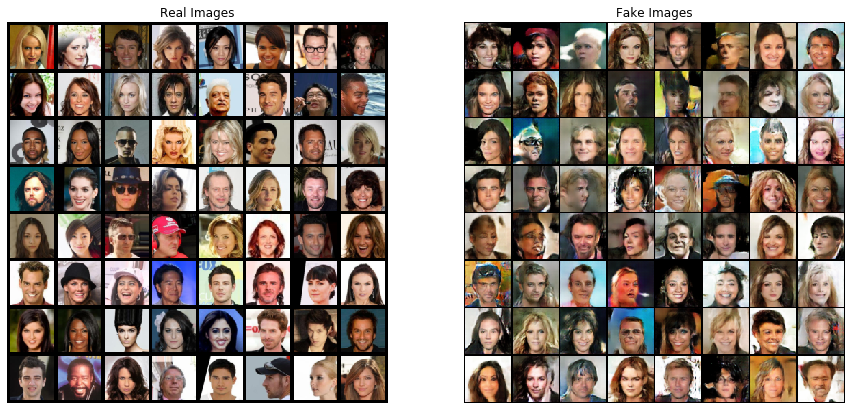

[4/10][0/1583]	Loss_D: 1.0929	Loss_G: 0.8052	D(x): 0.4303	D(G(z)): 0.0733 / 0.4992
2019-11-07 14:33:38.627664
[4/10][50/1583]	Loss_D: 0.5786	Loss_G: 2.2236	D(x): 0.7955	D(G(z)): 0.2632 / 0.1320
2019-11-07 14:33:58.715409
[4/10][100/1583]	Loss_D: 0.7019	Loss_G: 0.9179	D(x): 0.5600	D(G(z)): 0.0543 / 0.4525
2019-11-07 14:34:18.799002
[4/10][150/1583]	Loss_D: 0.8555	Loss_G: 1.8429	D(x): 0.6231	D(G(z)): 0.2377 / 0.1981
2019-11-07 14:34:38.916967
[4/10][200/1583]	Loss_D: 0.5069	Loss_G: 2.9326	D(x): 0.8706	D(G(z)): 0.2721 / 0.0662
2019-11-07 14:34:59.309156
[4/10][250/1583]	Loss_D: 0.5593	Loss_G: 3.4037	D(x): 0.8955	D(G(z)): 0.3290 / 0.0446
2019-11-07 14:35:19.524272
[4/10][300/1583]	Loss_D: 0.7130	Loss_G: 1.8187	D(x): 0.6046	D(G(z)): 0.1262 / 0.2169
2019-11-07 14:35:39.811725
[4/10][350/1583]	Loss_D: 0.5108	Loss_G: 3.1606	D(x): 0.8741	D(G(z)): 0.2802 / 0.0580
2019-11-07 14:36:00.100010
[4/10][400/1583]	Loss_D: 0.9163	Loss_G: 4.2972	D(x): 0.9319	D(G(z)): 0.5104 / 0.0193
2019-11-07 14:36:20.41

In [0]:
# Training Loop
import datetime

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

iters = 0
num_epochs = 10
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            print(datetime.datetime.now())
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
    
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    #%%capture
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

    HTML(ani.to_jshtml())

    # Grab a batch of real images from the dataloader
    real_batch = next(iter(dataloader))

    # Plot the real images
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    # Plot the fake images from the last epoch
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list[-1],(1,2,0)))
    plt.show()